# Figure 6
1. Images lie on the shell

In [1]:
from utils import *
from plot_params import *
from scipy.stats import pearsonr, kurtosis, ks_2samp
from scikit_posthocs import posthoc_dunn
from scipy.stats import iqr, wilcoxon
from scipy.special import xlogy
from scipy.spatial.distance import pdist
from itertools import compress

In [21]:
save = True
savepath = r'D:\Data\DeepMouse\Figures\Figure6'

In [3]:
# Plot functions
def plot_box(data, label, figsize=(6,5), cs=['r', [.3]*3]):
    '''Plot data as boxplots'''
    lw = 1
    fig, ax = pl.subplots(figsize=figsize)
    bp = ax.boxplot(data, showfliers=False, widths=0.6, patch_artist=True, medianprops=dict(color='k', linewidth=lw), boxprops=dict(linewidth=lw), whiskerprops=dict(linewidth=lw),
               capprops=dict(linewidth=lw))
    
    for patch, color in zip(bp['boxes'], cs):
        patch.set_facecolor(color)

    ax.set_xticklabels(label)
    return fig


In [4]:
fp = r'D:\Data\DeepMouse\Results\generalisation\activations_filtered2.npy'
data = np.load(fp, allow_pickle=1).item()
data_sum = []
for i, region in enumerate(regions):
    own = data[region][i]
    mask = np.ones(len(regions)+1).astype(bool)
    mask[i] = False
    mask[-1] = False
    other = np.concatenate(list(compress(data[region], mask)), axis=0)
    nat = data[region][-1]
    data_sum.append([own, other, nat])

In [18]:
# Calculate statistics for own, other, and nat stims
popvar = np.array([[iqr(data_sum[i][j], axis=1) for j in range(2)] for i in range(len(regions))])
popmean = np.array([[np.median(data_sum[i][j], axis=1) for j in range(2)] for i in range(len(regions))])
neuronvar = np.array([[iqr(data_sum[i][j], axis=0) for j in range(2)] for i in range(len(regions))])
neuronmean = np.array([[np.median(data_sum[i][j], axis=0) for j in range(2)] for i in range(len(regions))])
neuron25p = np.array([[np.percentile(data_sum[i][j], 10, axis=0) for j in range(2)] for i in range(len(regions))])
neuron75p = np.array([[np.percentile(data_sum[i][j], 90, axis=0) for j in range(2)] for i in range(len(regions))])
neuronkurt = np.array([[kurtosis(data_sum[i][j], axis=0) for j in range(2)] for i in range(len(regions))])
popkurt = np.array([[kurtosis(data_sum[i][j], axis=1) for j in range(2)] for i in range(len(regions))])


# Aggregate across regions
summary_popvar = [np.concatenate([popvar[i][j] for i in range(len(regions))]) for j in range(2)]
summary_popmean = [np.concatenate([popmean[i][j] for i in range(len(regions))]) for j in range(2)]
summary_neuronvar = [np.concatenate([neuronvar[i][j] for i in range(len(regions))]) for j in range(2)]
summary_neuron25p = [np.concatenate([neuron25p[i][j] for i in range(len(regions))]) for j in range(2)]
summary_neuron75p = [np.concatenate([neuron75p[i][j] for i in range(len(regions))]) for j in range(2)]
summary_neuronmean = [np.concatenate([neuronmean[i][j] for i in range(len(regions))]) for j in range(2)]
summary_neuronkurt = [np.concatenate([neuronkurt[i][j] for i in range(len(regions))]) for j in range(2)]
summary_popkurt = [np.concatenate([popkurt[i][j] for i in range(len(regions))]) for j in range(2)]

# Pooled distribution own vs other
pooled_own = np.concatenate([np.concatenate(data_sum[i][0]) for i, region in enumerate(regions)])
pooled_other = np.concatenate([np.concatenate(data_sum[i][1]) for i, region in enumerate(regions)])

c:\Users\rudit\anaconda3\envs\mnp_torch\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
c:\Users\rudit\anaconda3\envs\mnp_torch\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\rudit\anaconda3\envs\mnp_torch\lib\site-packages\ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays w

In [6]:
def plot_distribution(own, other, bins, figsize=(6,5)):
    fig, ax = pl.subplots(figsize=figsize)
    ax.hist(own, bins=bins, density=1, color='r', alpha=.5)
    ax.hist(own, bins=bins, color=np.array([1,0,0,1])*np.array([0.8,0.8,0.8,1]), histtype='step', linewidth=1, density=1)
    ax.hist(other, bins=bins, density=1, color='k', alpha=.5)
    ax.hist(other, bins=bins, color=np.array([0,0,0,1])*np.array([0.8,0.8,0.8,1]), histtype='step', linewidth=1, density=1)
    ax.set_ylim(0,0.45)
    ax.set_xlim(bins.min(), bins.max())
    ax.set_xticks([-4,-2,0,2,4])

    ax2 = ax.twinx()
    ax2.plot(np.sort(own), np.arange(own.shape[0])/own.shape[0], 'r-', lw=1)
    ax2.plot(np.sort(other), np.arange(other.shape[0])/other.shape[0], 'k-', lw=1)
    ax2.set_ylim(0,1)
    ax2.spines['right'].set_visible(True)
    ax2.set_yticks([0,0.25,0.5,0.75,1])
    ax2.set_yticklabels(['0.0', '', '0.5', '', '1.0'])
    return fig

def plot_percentiles(data25, data75, figsize=(6,5)):
    fig, ax = pl.subplots(figsize=figsize)
    lw = 1
    bp1 = ax.boxplot(data25, showfliers=False, widths=0.6, patch_artist=True, medianprops=dict(color='k', linewidth=lw), 
                     boxprops=dict(linewidth=lw), whiskerprops=dict(linewidth=lw), capprops=dict(linewidth=lw))
    bp2= ax.boxplot(data75, showfliers=False, widths=0.6, patch_artist=True, medianprops=dict(color='k', linewidth=lw), 
                     boxprops=dict(linewidth=lw), whiskerprops=dict(linewidth=lw), capprops=dict(linewidth=lw))
    
    return fig

def plot_percentiles2(data25, data75, figsize=(6,5), ylabel=''):
    '''Plot wdf data as boxplots'''
    fig, ax = pl.subplots(figsize=figsize)

    lw = 0.5
    x = np.arange(1,3)
    for j in range(data25[0].shape[0]):
        ax.plot(x, [data25[0][j], data25[1][j]], '-', lw=.05, alpha=.2, marker='.', ms=0.5, color=[.5]*3)

    ax.plot(x, [np.median(data25[0]), np.median(data25[1])], ls='-', marker='s', color='k', lw=1, ms=3)
    ax.plot(x[0], [np.median(data25[0])], ls='-', marker='s', color='r',  ms=3)

    for j in range(data75[0].shape[0]):
        ax.plot(x+2, [data75[0][j], data75[1][j]], '-', lw=.05, alpha=.2, marker='.', ms=0.5, color=[.5]*3)

    ax.plot(x+2, [np.median(data75[0]), np.median(data75[1])], ls='-', marker='s', color='k', lw=1, ms=3)
    ax.plot(x[0]+2, [np.median(data75[0])], ls='-', marker='s', color='r',  ms=3)
    ax.set_xticks([])
    ax.set_xlim(0.5,4.5)

    return fig

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


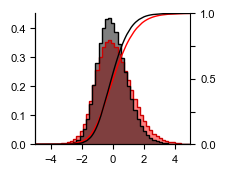

In [16]:
# Plot pooled distributions
fig1 = plot_distribution(pooled_own, pooled_other, bins=np.linspace(-5,5,50), figsize=(2., 1.7))
if save:
    fig1.savefig(os.path.join(savepath, 'example_neuron_distribution_pooled.eps'), bbox_inches='tight')

MannwhitneyuResult(statistic=11735125.0, pvalue=0.0)


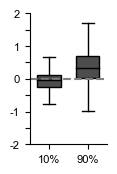

In [28]:
fig2 = plot_box([summary_neuron25p[0] - summary_neuron25p[1], summary_neuron75p[0] - summary_neuron75p[1]], ['10%', '90%'], figsize=(1.,1.7), cs=[[.3]*3]*2)
pl.axhline(0, ls='--', color=[.5]*3)
pl.ylim(-2,2)
pl.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2], ['-2', '', '-1', '', '0', '', '1', '','2'])
if save:
    fig2.savefig(os.path.join(savepath, 'percentiles_delta.eps'), bbox_inches='tight')

print(mannwhitneyu(summary_neuron25p[0] - summary_neuron25p[1], summary_neuron75p[0] - summary_neuron75p[1]))

WilcoxonResult(statistic=10089132.0, pvalue=8.217998615428963e-68)
WilcoxonResult(statistic=3519745.0, pvalue=0.0)


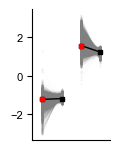

In [24]:
fig3 = plot_percentiles2(summary_neuron25p, summary_neuron75p, figsize=(1.,1.7))
if save:
    fig3.savefig(os.path.join(savepath, 'percentiles_all.tif'), bbox_inches='tight', dpi=300)
    
print(wilcoxon(summary_neuron25p[0], summary_neuron25p[1]))
print(wilcoxon(summary_neuron75p[0], summary_neuron75p[1]))

WilcoxonResult(statistic=12475720.0, pvalue=5.049321163293333e-05)
WilcoxonResult(statistic=4935427.0, pvalue=0.0)


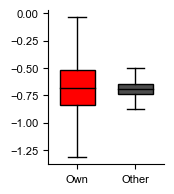

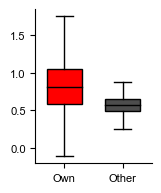

In [801]:
fig = plot_box(summary_neuron25p[:2], ['Own', 'Other'], figsize=(1.5,2))
fig = plot_box(summary_neuron75p[:2], ['Own', 'Other'], figsize=(1.5,2))
print(wilcoxon(summary_neuron25p[0], summary_neuron25p[1]))
print(wilcoxon(summary_neuron75p[0], summary_neuron75p[1]))

MannwhitneyuResult(statistic=168193507.0, pvalue=0.0)


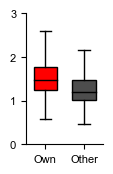

In [895]:
fig4 = plot_box(summary_popvar, ['Own', 'Other'], figsize=(1.,1.7))
pl.ylim(0, 3)
if save:
    fig4.savefig(os.path.join(savepath, 'popvar.eps'), bbox_inches='tight')

print(mannwhitneyu(summary_popvar[0], summary_popvar[1]))

WilcoxonResult(statistic=2019157.0, pvalue=0.0)


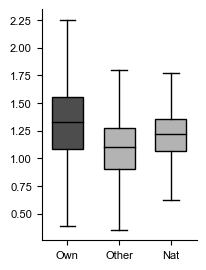

In [ ]:
fig = plot_box(summary_neuronvar, ['Own', 'Other', 'Nat'], figsize=(2,3))
print(wilcoxon(summary_neuronvar[0], summary_neuronvar[1]))

WilcoxonResult(statistic=7878430.5, pvalue=1.1606263550439754e-194)


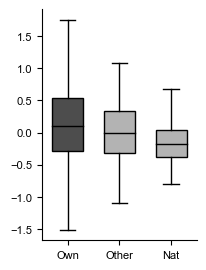

In [ ]:
fig = plot_box(summary_neuronmean, ['Own', 'Other', 'Nat'], figsize=(2,3))
print(wilcoxon(summary_neuronmean[0], summary_neuronmean[1]))

MannwhitneyuResult(statistic=145691465.0, pvalue=5.093820958703355e-171)


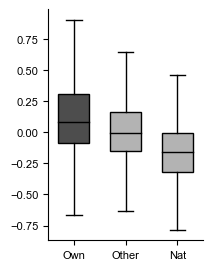

In [ ]:
fig = plot_box(summary_popmean, ['Own', 'Other', 'Nat'], figsize=(2,3))
print(mannwhitneyu(summary_popmean[0], summary_popmean[1]))

0.1557399444282055
-0.020523224025964737
0.05489462614059448
0.097701296210289
-0.05005814880132675
-0.040383823215961456
WilcoxonResult(statistic=12284626.0, pvalue=3.0228406234186556e-07)


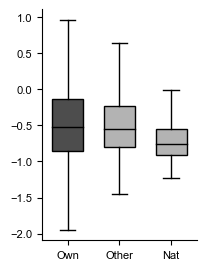

In [ ]:
fig = plot_box(summary_neuron25p, ['Own', 'Other', 'Nat'], figsize=(2,3))
for i in range(6):
    print(np.median(neuron25p[i][0] - neuron25p[i][1]))
print(wilcoxon(summary_neuron25p[0], summary_neuron25p[1]))

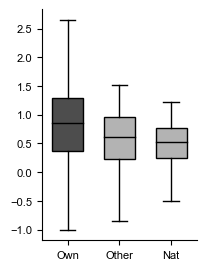

In [ ]:
fig = plot_box(summary_neuron75p, ['Own', 'Other', 'Nat'], figsize=(2,3))
# print(wilcoxon(summary_neuron75p[0], summary_neuron25p[1]))

WilcoxonResult(statistic=4511176.5, pvalue=0.0)


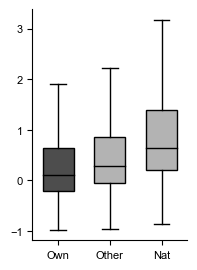

In [ ]:
fig = plot_box(summary_neuronkurt, ['Own', 'Other', 'Nat'], figsize=(2,3))
print(wilcoxon(summary_neuronkurt[0], summary_neuronkurt[2]))

MannwhitneyuResult(statistic=181542307.5, pvalue=8.339898574710868e-68)


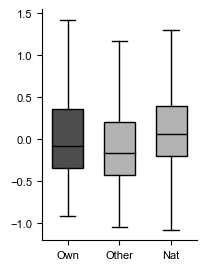

In [ ]:
fig = plot_box(summary_popkurt, ['Own', 'Other', 'Nat'], figsize=(2,3))
print(mannwhitneyu(summary_popkurt[0], summary_popkurt[2]))

## In vivo validation

In [ ]:
# Functions
def unpack_data(data):
    '''Given a dictionary with keys in regions, unpack the data into a list of len(regions) with first elements is own and second is nat'''
    own = np.concatenate([data[region][0] for i, region in enumerate(regions)])
    nat = np.concatenate([data[region][1] for i, region in enumerate(regions)])
    
    return [own, nat]

In [ ]:
invivo_popvar = np.load(r'D:\Data\DeepMouse\Results\tuning_dynamics\popvariance_validation.npy', allow_pickle=True).item()
invivo_neuronvar = np.load(r'D:\Data\DeepMouse\Results\tuning_dynamics\neuronvariance_validation.npy', allow_pickle=True).item()
invivo_neuronmean = np.load(r'D:\Data\DeepMouse\Results\tuning_dynamics\mean_validation.npy', allow_pickle=True).item()

invivo_popvar = unpack_data(invivo_popvar)
invivo_neuronvar = unpack_data(invivo_neuronvar)
invivo_neuronmean = unpack_data(invivo_neuronmean)

MannwhitneyuResult(statistic=8024269.5, pvalue=6.449934862714645e-09)


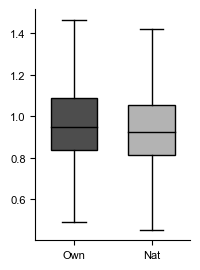

In [ ]:
fig = plot_box(invivo_popvar, ['Own', 'Nat'], figsize=(2,3))
print(mannwhitneyu(invivo_popvar[0], invivo_popvar[1]))

WilcoxonResult(statistic=486694.0, pvalue=2.0006909187373378e-26)


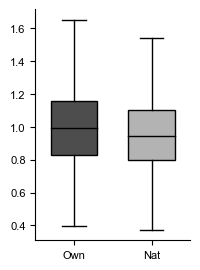

In [ ]:
fig = plot_box(invivo_neuronvar, ['Own', 'Nat'], figsize=(2,3))
print(wilcoxon(invivo_neuronvar[0], invivo_neuronvar[1]))

WilcoxonResult(statistic=364267.0, pvalue=2.2303492824038166e-63)


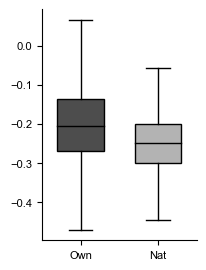

In [ ]:
fig = plot_box(invivo_neuronmean, ['Own', 'Nat'], figsize=(2,3))
print(wilcoxon(invivo_neuronmean[0], invivo_neuronmean[1]))

## Tuning curves

In [ ]:
# Functions
def im_dist(im1, im2):
    return ((im1-im2)**2).sum()


def get_percentile_bounds(data, N=10):
    '''Get the indices of the percentiles'''
    idx = np.argsort(data)
    boundaries = np.array([np.percentile(idx, p) for p in np.linspace(0,100,N+1)]).astype(int)
    return boundaries[::-1]

def get_tuning_curve(data, images, N=10):
    '''Construct a tuning curve iteratively'''
    assert data.shape[0] == images.shape[0]
    data_sorted = np.argsort(data)
    boundaries = get_percentile_bounds(data_sorted, N=N)
    tuning_curve = []
    for i in range(N):
        if i < 100:
            # Choose an image at random
            im_i = np.random.choice(np.arange(boundaries[i+1], boundaries[i]))
            im = images[data_sorted[im_i]]  
            tuning_curve.append(im)
            continue
        else:
            # Find the image that is closest to the previous
            im_p = images[np.arange(boundaries[i+1], boundaries[i])]
            d = np.array([im_dist(tuning_curve[-1], im) for im in im_p])
            im = im_p[np.argmin(d)]
            tuning_curve.append(im)

    return tuning_curve


In [ ]:
# Load in data
fp_cross = r'D:\Data\DeepMouse\Results\generalisation'
fp_ims = r'D:\Data\DeepMouse\Results\optstims\RF_aligned'
v1_activity = np.load(os.path.join(fp_cross, f"cross_presentation_LM.npy"), allow_pickle=True).item()['LM']
images = np.squeeze(np.load(os.path.join(fp_ims, f"optStim_masked_LM.npy")))

In [ ]:
tuning_curve = get_tuning_curve(v1_activity[:,800], images, N=10)

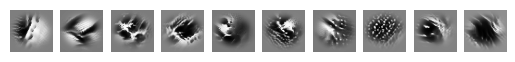

In [ ]:
fig, ax = pl.subplots(nrows=1, ncols=10)
for i, a in enumerate(ax.reshape(-1)):
    a.imshow(tuning_curve[i], cmap='gray')
    a.axis('off')